In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from typing import Tuple

In [3]:
RHO=997 #kg/m^3
G = 9.8 #m/s^2 #pho* g* h [kg/m/s^2 = N/m^2]
P_ATM = 101325 #Pa

rng = np.random.default_rng()

In [4]:
#水深からその場所での圧力推定値を出力する
def z_to_Pa(z:float, v=0.5):
  return (RHO*G*z+0.5*RHO*v**2) + P_ATM # N/m^2

In [5]:
#set initial value
time_devided = 65 #6.5s
pressure_former = z_to_Pa(1) #水深1m　速度0.5m/sの時のpressure
pressure_latter = z_to_Pa(0.5) #水深0.5m　速度0.5m/sの時のpressure
time_range = 100 #2s

In [7]:
def normalize(df_result: pd.DataFrame) -> pd.DataFrame:
    if df_result.shape[1] != 9:
        raise ValueError(f"Input has {df_result.shape[1]} columns; should be 9")
    df=df_result.set_axis(
        [
            "time",
            "acc_x",
            "acc_y",
            "acc_z",
            "pitch",
            "roll",
            "yaw",
            "pressure",
            "flag",
        ],
        axis='columns'
    )
    return df


In [8]:
#pressureのスコアの計算
def score(df_result: pd.DataFrame, target_pressure: float) -> Tuple[float,int]:
    err_square = (df_result - target_pressure)**2
    loss_square = err_square["pressure"].head(time_range).sum()

    #lossの最小
    min_loss_square = loss_square
    min_loss_index = 0

    for i in range(100000):
        if (i + time_range) >= len(df_result.index):
            break 

        loss_square = loss_square + err_square.at[i + time_range, "pressure"] - err_square.at[i, "pressure"]
        # Update minimum loss and corresponding index
        if loss_square < min_loss_square:
            min_loss_square = loss_square
            min_loss_index = i+1

    score = np.sqrt(min_loss_square / time_range)
    return score, min_loss_index

In [9]:
#pressureのスコア計算で取ったサンプルからyawrollのスコア計算を行う
def culc_score_yawroll(df_result: pd.DataFrame, start_index) -> Tuple[float,float]:
  score_roll = df_result["roll"].iloc[start_index:start_index+time_range].std()
  score_yaw = df_result["yaw"].iloc[start_index:start_index+time_range].std()
  
  return score_roll, score_yaw

In [10]:
def print_result(df_result:pd.DataFrame, dir_out='./output/', filename=datetime.datetime.now().strftime("%Y-%m-%d %H%M%S")):
   #normalize
   df = normalize(df_result)
   #trunc
   df_trunc = df[df["flag"] >= 1].reset_index(drop=True)

   #devide data into former and latter one
   df_former = df_trunc[df_trunc["time"] < time_devided].reset_index(drop=True)
   df_latter = df_trunc[df_trunc["time"] > time_devided].reset_index(drop=True)

   print("df_former shape: " + str(df_former.shape))
   print("df_latter shape: " + str(df_latter.shape))


   #culculating the score("pressure")
   score_val_former, former_min_loss_index = score(df_former,pressure_former)
   print("former_min_loss_index: " + str(former_min_loss_index))
   score_val_latter, latter_min_loss_index = score(df_latter,pressure_latter)
   print("latter_min_loss_index: " + str(latter_min_loss_index))
   score_val = score_val_former + score_val_latter
   score_yaw_former, score_roll_former = culc_score_yawroll(df_former, former_min_loss_index) 
   score_yaw_latter, score_roll_latter = culc_score_yawroll(df_latter, latter_min_loss_index)
   score_yaw_val = score_yaw_former + score_yaw_latter
   score_roll_val = score_roll_former + score_roll_latter

   fig1,axes=plt.subplots(3,1,figsize=(8,12))
   
   fig1.suptitle(f'Score(Pressure) = {score_val:.2f}, Score(Yaw) = {score_yaw_val: .2f}, Score(Roll) = {score_roll_val: .2f}')
   fig1.set_tight_layout('tight')
   # Accel
   axes[0].set_xlabel('Time[s]')
   axes[0].set_ylabel('Acceleration[$m/s^2$]')
   axes[0].plot(df_trunc['acc_x'],c='red',label='acc_x')
   axes[0].plot(df_trunc['acc_y'],c='green',label='acc_y')
   axes[0].plot(df_trunc['acc_z'],c='blue',label='acc_z')
   axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, )

   # Orientation
   axes[1].set_xlabel('Time[s]')
   axes[1].set_ylabel('Angle[deg]')
   axes[1].plot(df_trunc['pitch'],c='red',label='pitch')
   axes[1].plot(df_trunc['roll'],c='green',label='roll')
   axes[1].plot(df_trunc['yaw'],c='blue',label='yaw')
   axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, )

   # Orientation
   axes[2].set_xlabel('Time[10^-1 s]')
   axes[2].set_ylabel('Pressure[Pa]')
   axes[2].plot(df_trunc['pressure'],c='black',label='Result')
   axes[2].plot(df_trunc['pressure'].iloc[former_min_loss_index:former_min_loss_index+time_range],c='red',label='former sample')
   axes[2].plot(df_trunc['pressure'].iloc[latter_min_loss_index + len(df_former.index):latter_min_loss_index+time_range + len(df_former.index)],c='red',label='latter sample')

   #axes[2].plot(df_target['pressure'],c='black',ls='--',label='Target')
   axes[2].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, )
   
   # Output
   path_out = Path(dir_out)
   if not path_out.exists():
      path_out.mkdir(parents=True, exist_ok=True)
   plt.savefig(path_out.joinpath(f"{filename}.png"), bbox_inches="tight")
   plt.savefig(path_out.joinpath(f"{filename}.pdf"), bbox_inches="tight")

df_former shape: (577, 9)
df_latter shape: (662, 9)
former_min_loss_index: 0
latter_min_loss_index: 515


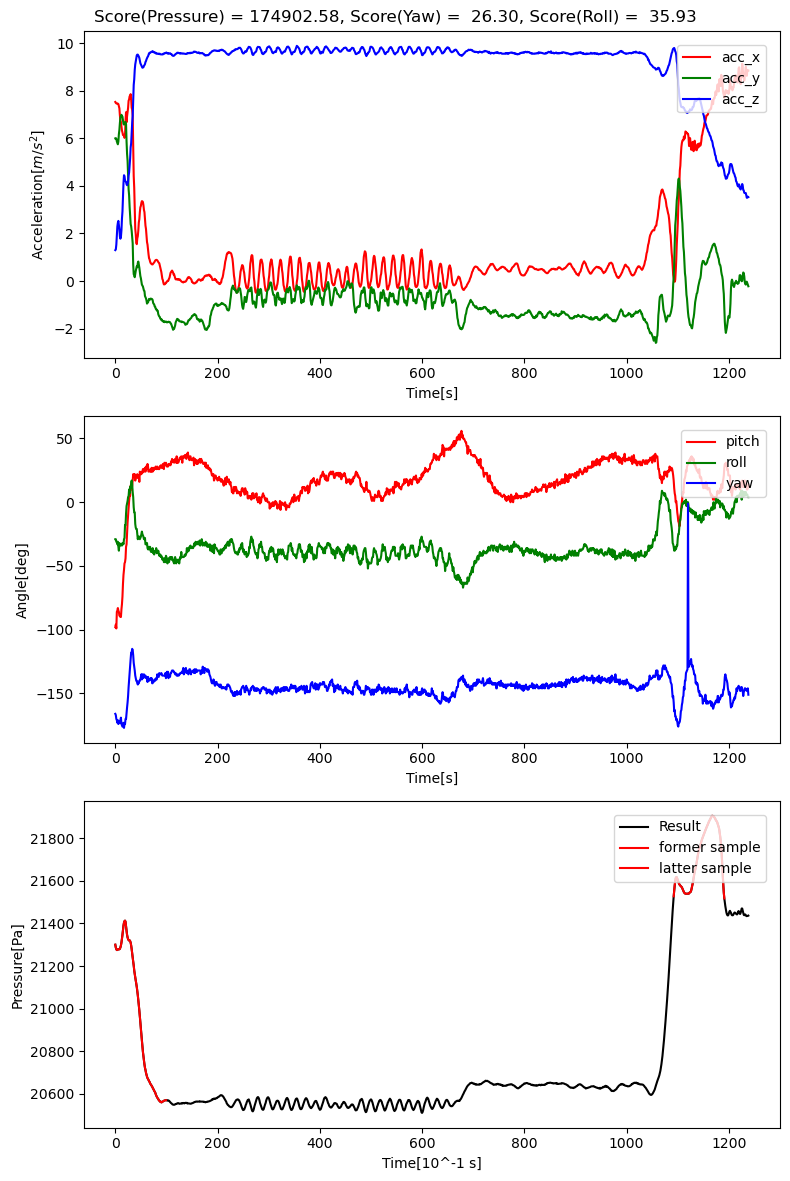

In [11]:
print_result(pd.read_csv("rawdata_submit_modified.csv"))